<a href="https://colab.research.google.com/github/ssroka/ML_with_IBM_GeoDN/blob/main/RI_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification Neural Net

This file uses a neural network to try to classify whether a given set of environmental conditions are likely to result in rapid intensification (RI).

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# sklearn
from sklearn.preprocessing import StandardScaler

# The usual suspects
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline


# Data Initialization


In [ ]:
N = 10000 # number of samples

In [ ]:
import pandas as pd

In [ ]:
df_diff = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PIvsMAXV_5_21.csv')
df_diff.keys()
df_diff = df_diff.dropna(axis = 0)

In [ ]:
print(df_diff)

       latitude  longitude                 time     Basin       Storm_name  \
0         13.00     113.75  1962-09-14 06:00:00  iotracks  Babe:babs:carla   
1         13.25     113.25  1962-09-14 12:00:00  iotracks  Babe:babs:carla   
2         13.75     112.75  1962-09-14 18:00:00  iotracks  Babe:babs:carla   
3         14.25     112.25  1962-09-15 00:00:00  iotracks  Babe:babs:carla   
4         14.75     111.75  1962-09-15 06:00:00  iotracks  Babe:babs:carla   
...         ...        ...                  ...       ...              ...   
10239     44.00     322.50  1966-07-29 12:00:00  attracks     Dorothy        
10240     44.50     322.50  1966-07-29 18:00:00  attracks     Dorothy        
10241     45.25     322.50  1966-07-30 00:00:00  attracks     Dorothy        
10242     46.00     322.75  1966-07-30 06:00:00  attracks     Dorothy        
10245     50.50     323.50  1966-07-31 06:00:00  attracks     Dorothy        

       Storm_year         Td         Ta         Ts         To  

### surface temperature [K]

In [ ]:
#Ts = np.random.randn(9196,1)*7+300 # synthetic data
Ts = np.array(df_diff['Ts'])

In [ ]:
print(np.shape(Ts))

(9197,)


### PI minus Vmax [m/s]

In [ ]:
#PI_Vmax = np.random.rand(N,1)*40+5 # synthetic data
PI_Vmax = np.array(df_diff['diff w/o R'])

In [ ]:
print(PI_Vmax[0])

73.85569939439418


In [ ]:
PI_Vmax = PI_Vmax.reshape((len(PI_Vmax),1))
Ts = Ts.reshape((len(PI_Vmax),1))

(array([  13.,  108.,  330.,  732., 1115., 1512., 1808., 2100., 1383.,
          96.]),
 array([-37.29948697, -21.91236545,  -6.52524393,   8.86187759,
         24.24899912,  39.63612064,  55.02324216,  70.41036368,
         85.7974852 , 101.18460673, 116.57172825]),
 <BarContainer object of 10 artists>)

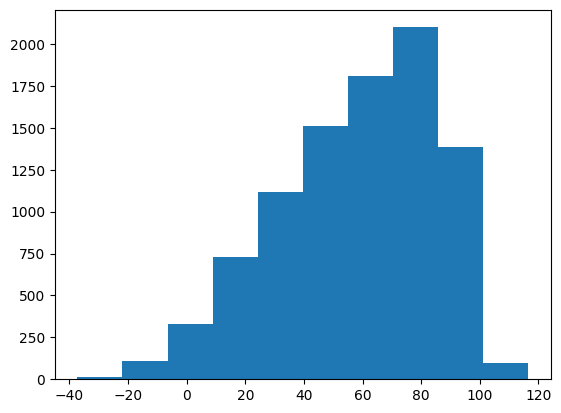

In [ ]:
# plt.hist(Ts)
plt.hist(PI_Vmax)

In [ ]:
# concatenate data

x = np.concatenate((Ts,PI_Vmax), axis = 1)

# make synthetic RI indicator
y = (Ts>307)|(PI_Vmax>25)

# # add noise
inds = np.random.choice(range(N),10) # pick 50 random indices (10% of N)
y[inds] = np.invert(y[inds])
# cast to 0,1
y = y.squeeze().astype(int)


In [ ]:
print(np.shape(x))

(9197, 2)


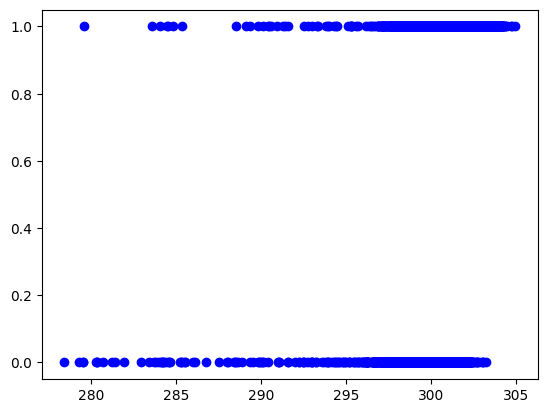

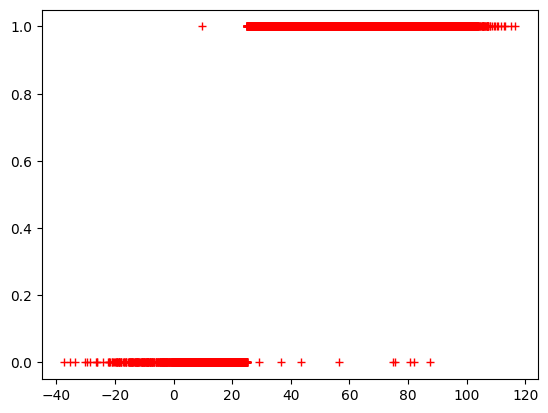

In [ ]:
plt.plot(x[:,0],y,'bo')
plt.show()
plt.plot(x[:,1],y,'r+')
plt.show()


### normalize data

In [ ]:
# standardize data (set all features to mean = 0 and standard deviation = 1)
scaler = StandardScaler()
scaler.fit(x)
x_standard = scaler.transform(x)

NameError: ignored

In [ ]:
x_standard

array([[-0.18163019,  0.58897123],
       [-0.2435144 ,  0.21595492],
       [-0.1963973 ,  0.33003894],
       ...,
       [-4.32620548, -2.73975851],
       [-4.54813149, -2.76419443],
       [-6.0715824 , -2.63866014]])

### Create data set

In [ ]:
# create a class Data that Dataloader can use

class Data(Dataset):
  # input:
  # x = Nxm numpy array were N is samples and m is features
  # y = Nx1 numpy array
    def __init__(self,x,y):
        self.x=torch.from_numpy(x).to(torch.float32) # convert numpy array to tensor
        self.y=torch.from_numpy(y).to(torch.float32) # convert numpy array to tensor
        self.len=self.x.shape[0]
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

NameError: ignored

In [ ]:
data_set = Data(x_standard,y)
batch_size = 100
train_loader = DataLoader(dataset=data_set, batch_size=batch_size)

# Define Net


In [ ]:
D_in = np.size(x,axis=1) # number of features
H = 2                    # 2 neurons in the hidden layer
D_out = 1                # T/F

NameError: ignored

In [ ]:
# model = nn.Sequential(
#     nn.Linear(D_in,H),
#     nn.ReLU(),
#     nn.Linear(H,D_out))

# Build the model with Relu function

class NetRelu(nn.Module):

    # Constructor
    def __init__(self, D_in, H1, D_out):
        super(NetRelu, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

    # Prediction
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x

In [ ]:
train_loader = DataLoader(dataset=data_set, batch_size=200)
model = NetRelu(2,2,1)
learning_rate=0.1
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(y,yhat):
  acc = np.mean(y.detach().numpy().astype(int)==yhat.detach().numpy().astype(int))
  return acc

NameError: ignored

In [ ]:
def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    ACC = []
    COST = []
    for epoch in range(epochs):
        total_loss=0
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x.view(-1,2))
            loss = criterion(yhat, y.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #cumulative loss 
            total_loss+=loss.item()
        ACC.append(accuracy(data_set.y,model(data_set.x).view(-1)))
        COST.append(total_loss)
    return [ACC,COST]

In [ ]:
output = train(data_set,model,criterion,train_loader,optimizer,epochs=200)

In [ ]:
print(output)

[[0.1345003805588779, 0.144503642492117, 0.36348809394367726, 0.5925845384364467, 0.6909861911492878, 0.7421985430031532, 0.7794933130368599, 0.8064586278134174, 0.8253778406001957, 0.8383168424486246, 0.8510383820811134, 0.8620202239860825, 0.8706099815157117, 0.8787648146134609, 0.8835489833641405, 0.8878982276829401, 0.8943133630531696, 0.8986626073719691, 0.9020332717190388, 0.9035555072306187, 0.911275415896488, 0.9099706426008481, 0.9172556268348374, 0.9151897357834077, 0.9229096444492769, 0.9199739045340872, 0.9266065021202566, 0.9234532999891268, 0.9300858975752962, 0.9258453843644667, 0.933239099706426, 0.9287811242796564, 0.9361748396216157, 0.9313906708709362, 0.9375883440252256, 0.933239099706426, 0.9380232684571056, 0.944655866043275, 0.944003479395455, 0.9451995215831249, 0.9411764705882353, 0.9320430575187562, 0.932912906382516, 0.9353049907578558, 0.9373708818092856, 0.9385669239969555, 0.9400891595085354, 0.9422637816679352, 0.9431336305316951, 0.944655866043275, 0.945

In [ ]:
x1_plt = data_set.x.detach().numpy()[:,0]
x2_plt = data_set.x.detach().numpy()[:,1]
y_plt = data_set.y.detach().numpy()

inds_T = y_plt>0.5 # if true
inds_F = y_plt<0.5 # if true

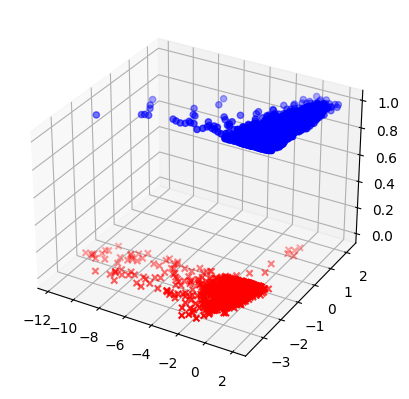

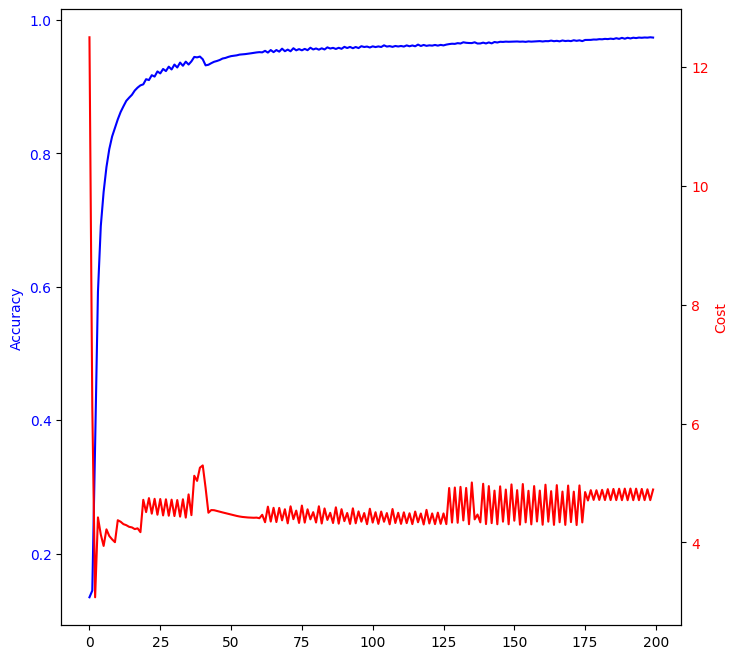

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1_plt[inds_T],x2_plt[inds_T],y_plt[inds_T],marker='o',color='b')
ax.scatter(x1_plt[inds_F],x2_plt[inds_F],y_plt[inds_F],marker='x',color='r')
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.plot(output[0],'b')
ax1.set_ylabel("Accuracy", color='b')
ax1.tick_params(axis="y", labelcolor='b')

ax2.plot(output[1],'r')
ax2.set_ylabel("Cost", color='r')
ax2.tick_params(axis="y", labelcolor='r')
